In [23]:
import os
import pandas as pd
from pandas import rolling_median
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer
from detect_peaks import detect_peaks

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import dump_svmlight_file

from sklearn.feature_selection import RFECV





In [24]:
## consts :
dataSource = r'../raw-data/utf8'
SAMPLE_FREQ = 50 
FILE_MARGINES = 5* SAMPLE_FREQ  ## number of samples to ignore in the  start and in the end of the file (5 seconds )  
WINDOW_SIZE = 2 * 128  ## sliding window size 
PEAKS_WINDOW_SIZE = 5*WINDOW_SIZE  ## sliding window size for peaks count feature

DEVICE_MODE_LABELS = ['pocket','swing','texting','talking','whatever'] 
USER_MODE_LABELS = ['walking','fastwalking','stairs','static','whatever'] 

FEATURES = ['timestamp',
            'agforce','agyro',               ## avarage 
            'mgforce','mgyro',               ## median
            'vgforce','vgyro',               ## variance 
            'iqrforce','iqqgyro',            ## iqr
            'entforce','entgyro',            ## entropy
            #'gforcegyrocorr',               ## correlation
            'skforce', 'skgyro',             ## skewness
            'kuforce','kugyro',              ## kurtosis 
            'MultiGyroAcc',                  ## max  gyro * max acc
            'maxgforce','maxgyro',           ## max  
            'maxgforceabs','maxgyroabs',     ## abs max 
            'mingforce','mingyro',           ## min 
            'mingforceabs','mingyroabs',     ## abs min
            'ampgforce','ampgyro' ,           ## amplitude |max - min|
            'peaksgforce','peaksgyro',       ## peaks count in PEAKS_WINDOW_SIZE
            'light'                          ## embient light sensor  
           ]


### Calulates high level features and add to given data frame add norm feature for g-force , gyro vectors calculates additional statistics features  on the norm properties using sliding window fill NaN values 

In [25]:
def RollingPercentile(values,a):
    res = np.percentile(values,a)
    return res  

In [26]:
def RollingEntropy(values):
    res = (-values*np.log2(values)).sum(axis=0)
    return res

In [27]:
def NormValues(values):
    Res = values/values.max()
    return Res

In [28]:
def LowPassFilter(values):
    threshold = values.mean()+3*values.std()
    ResE = rolling_median(values, window=15, center=True).fillna(method='bfill').fillna(method='ffill')
    #ResE = NormValues(ResEtemp)
    return ResE

In [29]:
def RemoveOutlier (values):
    threshold = values.mean()+3*values.std()
    ResEtemp = rolling_median(values, window=15, center=True).fillna(method='bfill').fillna(method='ffill')
    difference = np.abs(values - ResEtemp)
    outlier_idx = difference > threshold
    values[outlier_idx] = threshold
    #ResE = NormValues(ResEtemp)
    return values

In [30]:
    ## peaks detection :
    mph = 0 ## minimum peak height 
    mpd = 5 ## minimum peak distance = 20
    def peaks(values):
        return len(detect_peaks(values, mph, mpd, show=False))


In [31]:
# rolling window on 2d numpy array. return crrelation between first and second array colomn 
# input 2d array with 2 colomns and rolling window size 
# output: 1d array with correlation results  

def window_correlation(a,window_size):
    ## pad array start with zeros for rolling window compatibility 
    c = np.append(np.zeros((window_size,2),np.float64 ), a , axis=0)

    ## stacks windows : 
    interlaceing = np.hstack(c[i:1+i-window_size or None:1] for i in range(0,window_size) )
    
    # get left and right indices :
    l = interlaceing[:,range(0, 2*window_size, 2)] 
    r = interlaceing[:,range(1, 2*window_size, 2)]

    ## correlates left and right values 
    return  np.array([np.corrcoef(l[i] , r[i],rowvar=0)[0,1] for i in range(len(l)-1)])

# test method :
if 0 != 0 :
    v = np.linspace(0.0,20.0,20).reshape(10,2)
    print 'v= ' , v.shape ,v 
    print window_correlation(v,4)


In [32]:
def addFeatures(df):
    
    df['timestamp'] = df['time']
    
    ## norm calculations :
    df['gforce'] = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gyro'] = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2)     
    
   # remove outliers
    rawforce = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gforce'] = RemoveOutlier(rawforce)
    rawgyro = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2) 
    df['gyro'] =RemoveOutlier(rawgyro)

    ## calculates statistics features on rolling window :
    
    df['agforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).mean()
    df['agyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).mean()

    df['mgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).median()
    df['mgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).median()

    df['vgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()
    df['vgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()

    df['maxgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).max()
    df['maxgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).max()

    df['maxgforceabs'] = abs(df['maxgforce'])
    df['maxgyroabs']   = abs(df['maxgyro']) 

    df['mingforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).min()
    df['mingyro']  = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).min()

    df['mingforceabs'] = abs(df['mingforce'])
    df['mingyroabs']   = abs(df['mingyro']) 
    
    df['ampgforce'] = df['maxgforce'] - df['mingforce']
    df['ampgyro']  = df['maxgyro'] - df['mingyro']
    
    roll_force = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False)
    roll_gyro = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False)
        
    ## iqr calculations:

    q25 = roll_force.apply(RollingPercentile, [25.0])
    q75 = roll_force.apply(RollingPercentile, [75.0])
    q25 = roll_gyro.apply(RollingPercentile, [25.0])
    q75 = roll_gyro.apply(RollingPercentile, [75.0])
    df['iqrforce'] = q75 - q25
    df['iqqgyro'] = q75 - q25
    
    
    
    ## entropy calculations:
    df['entforce'] = roll_force.apply(RollingEntropy);
    df['entgyro'] = roll_gyro.apply(RollingEntropy);
    
    ## ratio calculations
    df['MultiGyroAcc'] = df['maxgforce']*df['maxgyro']
    
    df['skforce'] = roll_force.skew()
    df['skgyro'] = roll_gyro.skew()             
                                           
    df['kuforce'] = roll_force.kurt()
    df['kugyro'] = roll_gyro.kurt()             
    
    df['light'] = df['I'] if 'I' in df else 0.0 

    df['peaksgforce'] = df['gforce'].rolling(window=PEAKS_WINDOW_SIZE,min_periods=1 ,center=False).apply(peaks)
    df['peaksgyro'] = df['gyro'].rolling(window=PEAKS_WINDOW_SIZE,min_periods=1 ,center=False).apply(peaks)    
    
    ## gforce gyro correlation :
    df['gforcegyrocorr'] = window_correlation(df[['gforce','gyro']].values,WINDOW_SIZE)

    df.fillna(method='ffill', axis=0, inplace=True)

### Read csv data file , add label colomn by parsing the file name  add high level features , crop file edges  Todo : normlize , remove dc 

In [33]:
def loadFile(root,file):
    data=pd.read_csv(os.path.join(root,file))
    if len(data) < 500 :
        print (' only ' , len(data) , ' samples in file ', file , ' pass ')
        return pd.DataFrame()
    
    print('loading : ' , file) 

    print('loading : ' , len(data) , ' samples from ', file) 
    
    ## usefull property : 
    data['source']=file  

    ## default label values in case file name not contains label  
    data['devicemodeDescription']=DEVICE_MODE_LABELS[-1] ## 'whatever' label 
    data['devicemode'] = len(DEVICE_MODE_LABELS)

    ## search device mode label in file name and add as new properties :
    for label in DEVICE_MODE_LABELS:
        if label.lower() in file.lower():  
            data['devicemodeDescription']=label         ## label name 
            data['devicemode'] = DEVICE_MODE_LABELS.index(label)    ## label index 
            break
    
    ## add high level features 
    addFeatures(data)
        
    ## crop samples from start and from the end of the file :
    margin = min(len(data) / 2 - 1 , FILE_MARGINES)
    data.drop(data.index[range(0,margin)],axis=0,inplace=True)
    data.drop(data.index[range(-margin,-1)],axis=0,inplace=True)   
    ##  print(len(data) , ' samples after cropping ' , margin , 'samples from start-end of the file  ')
    return data 

In [34]:
def loadFiles(inputDir):
    print ('loading files from : ' , inputDir )
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [35]:
rdf = loadFiles(dataSource)
print('=========================================================')
print( 'total train samples ' , len(rdf) , ' from ' ,len(rdf.source.unique()),  ' files ')

('loading files from : ', '../raw-data/utf8')
('loading : ', 'RightPocket.csv')
('loading : ', 7486, ' samples from ', 'RightPocket.csv')


/home/yuval/anaconda2.4/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=True).median()
  This is separate from the ipykernel package so we can avoid doing imports until


('loading : ', 'TalkingLeftHandFromSignBack.csv')
('loading : ', 3223, ' samples from ', 'TalkingLeftHandFromSignBack.csv')
('loading : ', 'TalkingLeftHandNight1.csv')
('loading : ', 7360, ' samples from ', 'TalkingLeftHandNight1.csv')
('loading : ', 'TalkingLeftHandToSignChexk.csv')
('loading : ', 3366, ' samples from ', 'TalkingLeftHandToSignChexk.csv')
('loading : ', 'Texting2.csv')
('loading : ', 4268, ' samples from ', 'Texting2.csv')
('loading : ', 'SwingRightPhoneDownScBody.csv')
('loading : ', 9258, ' samples from ', 'SwingRightPhoneDownScBody.csv')
('loading : ', 'SwingRight2.csv')
('loading : ', 7244, ' samples from ', 'SwingRight2.csv')
('loading : ', 'swing3.csv')
('loading : ', 4931, ' samples from ', 'swing3.csv')
('loading : ', 'TextingRight.csv')
('loading : ', 5809, ' samples from ', 'TextingRight.csv')
('loading : ', 'swing2.csv')
('loading : ', 11819, ' samples from ', 'swing2.csv')
('loading : ', 'LeftPocketJeansNormalWalk.csv')
('loading : ', 6573, ' samples from '

In [14]:
rdf.head()

,Bx,By,Bz,I,Latitude,Longitude,MultiGyroAcc,Speed (m/s),Unnamed: 11,Unnamed: 12,...,skforce,skgyro,source,time,timestamp,vgforce,vgyro,wx,wy,wz
250,-23.7823,31.0425,31.3141,0.0,NaN,NaN,14.881794,NaN,NaN,NaN,...,0.725516,0.830360,RightPocket.csv,9.784,9.784,0.107086,2.300965,2.0873,-1.7908,0.2970
251,-23.7823,31.0425,31.3141,0.0,NaN,NaN,14.881794,NaN,NaN,NaN,...,0.729816,0.828129,RightPocket.csv,9.845,9.845,0.107154,2.292588,2.0873,-1.7908,0.2970
252,-23.7823,31.0425,31.3141,0.0,NaN,NaN,14.881794,NaN,NaN,NaN,...,0.734129,0.832409,RightPocket.csv,9.848,9.848,0.107218,2.284076,1.1153,-0.0765,1.5819
253,-31.2820,28.7933,26.3641,0.0,NaN,NaN,14.881794,NaN,NaN,NaN,...,0.738455,0.836674,RightPocket.csv,9.924,9.924,0.107278,2.275626,1.1153,-0.0765,1.5819
254,-31.2820,28.7933,26.3641,0.0,NaN,NaN,14.881794,NaN,NaN,NaN,...,0.742792,0.840924,RightPocket.csv,9.935,9.935,0.107333,2.267238,1.1153,-0.0765,1.5819


In [15]:
rdf.groupby('devicemodeDescription').devicemode.count()

devicemodeDescription
pocket     34894
swing      71363
talking    19589
texting    15254
Name: devicemode, dtype: int64

In [17]:
rdf.groupby('source').devicemode.count()

source
LeftPocketJeansNormalWalk.csv                      6074
Pocket2.csv                                        7551
PocketLeftAidePhoneDownScBodyLoose.csv             8257
PocketLeftNormalWalking.csv                        6025
RightPocket.csv                                    6987
SwingLeftNormal.csv                                5375
SwingRight2.csv                                    6745
SwingRightPhoneDown.csv                            7062
SwingRightPhoneDownScBody.csv                      8759
TalkingLeftHandFromSignBack.csv                    2724
TalkingLeftHandNight1.csv                          6861
TalkingLeftHandNight2.csv                          7137
TalkingLeftHandToSignChexk.csv                     2867
Texting2.csv                                       3769
TextingPointingDorwatd.csv                         6175
TextingRight.csv                                   5310
swing2.csv                                        11320
swing3.csv                               

#### visualize features 

LeftPocketJeansNormalWalk.csv


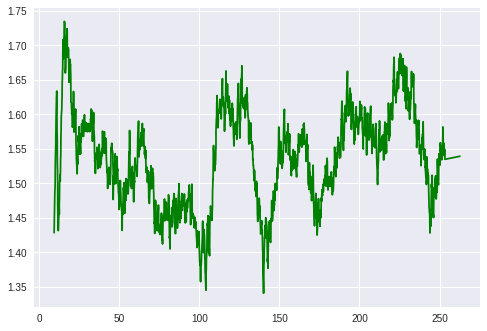

Pocket2.csv


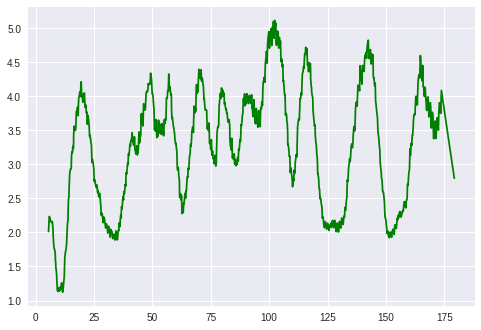

PocketLeftAidePhoneDownScBodyLoose.csv


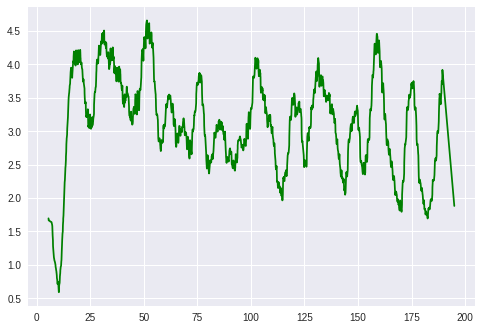

PocketLeftNormalWalking.csv


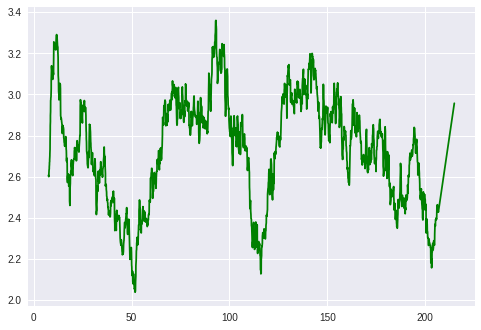

RightPocket.csv


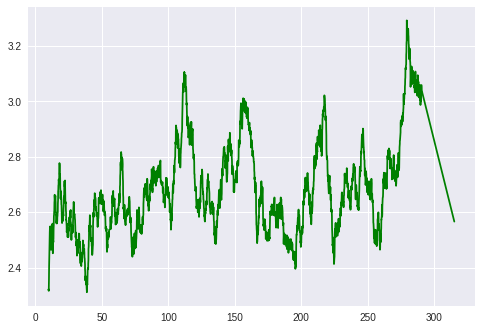

SwingLeftNormal.csv


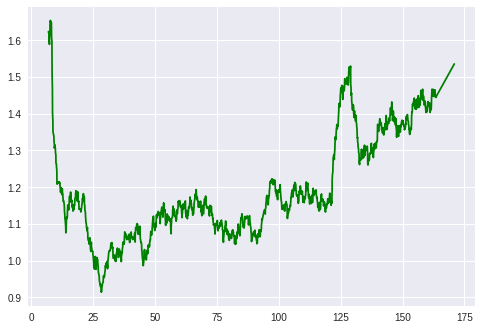

SwingRight2.csv


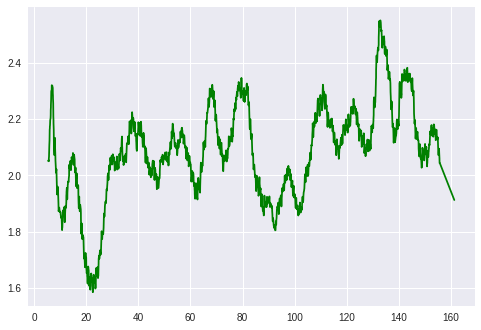

SwingRightPhoneDown.csv


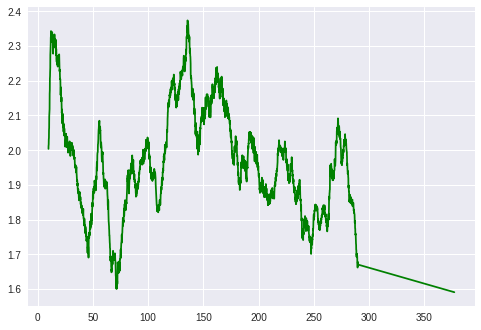

SwingRightPhoneDownScBody.csv


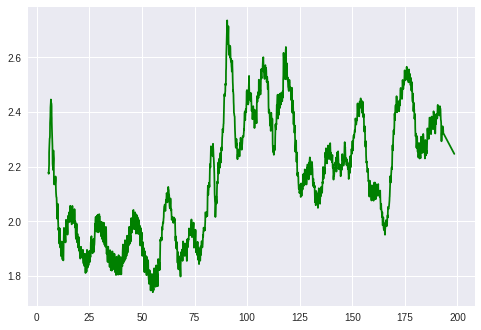

TalkingLeftHandFromSignBack.csv


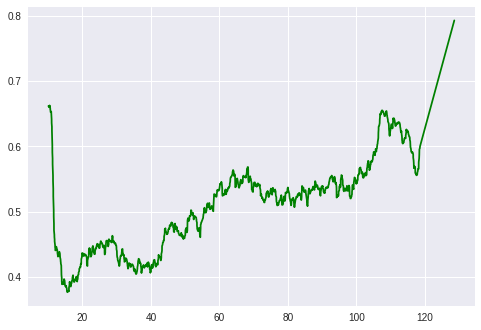

TalkingLeftHandNight1.csv


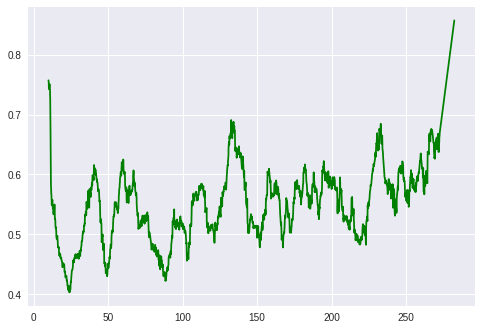

TalkingLeftHandNight2.csv


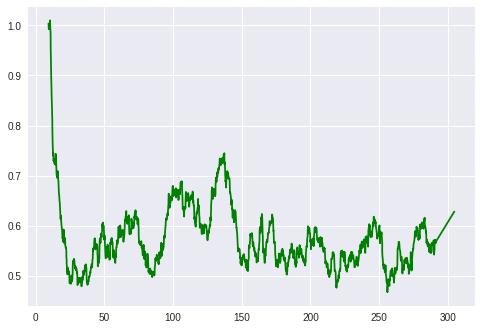

TalkingLeftHandToSignChexk.csv


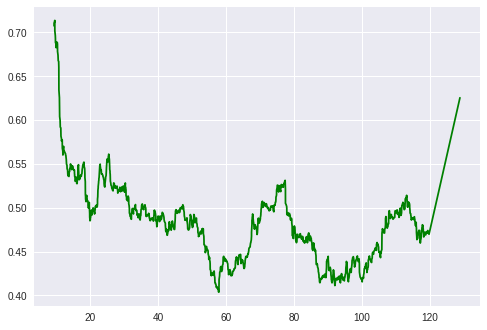

Texting2.csv


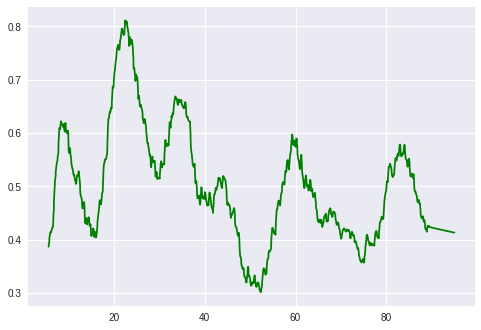

TextingPointingDorwatd.csv


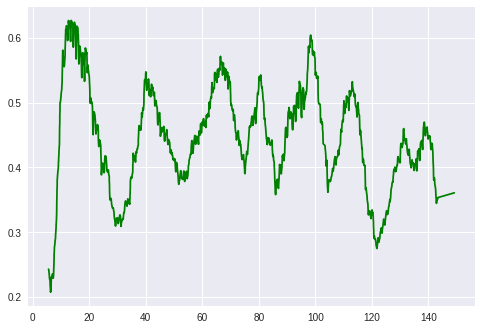

TextingRight.csv


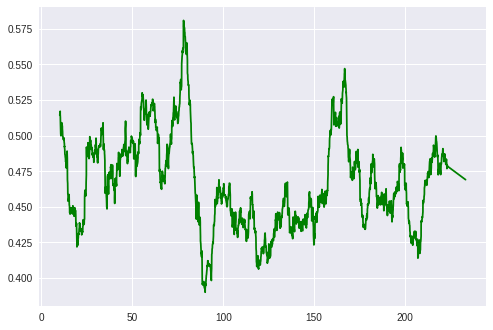

swing2.csv


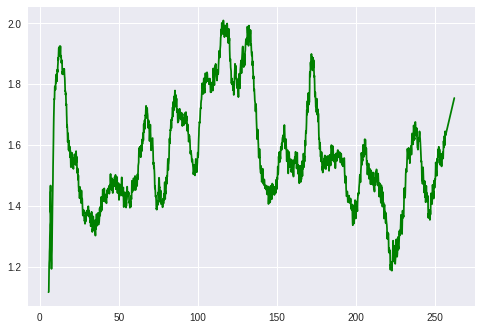

swing3.csv


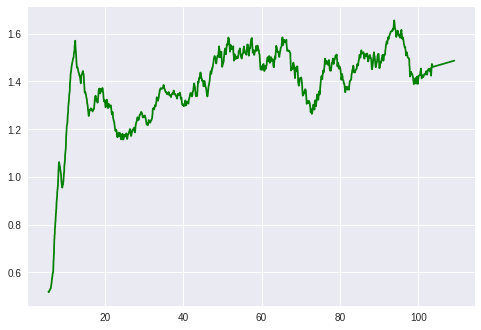

swing4.csv


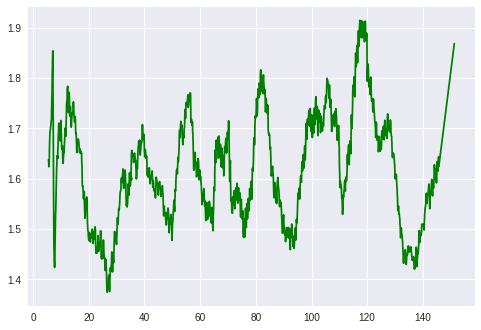

swingLeftHandPhoneDownScBody.csv


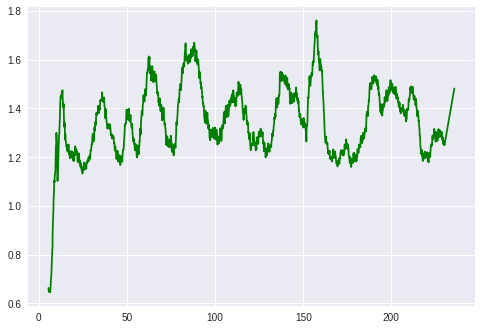

yuval-htc-swing_walking-2017-09-0316.04.51.csv


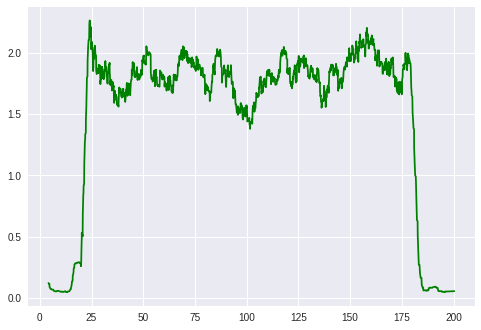

In [16]:
if 0==0:
    for s in rdf.groupby('source').source:
        print (s[0])
        yy = rdf[rdf.source == s[0]]
        plt.plot(yy.time,yy.agyro, 'g' ) 
        plt.show()


## cross_validation (  group by source proprty ) 
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds
The number of distinct groups has to be at least equal to the number of folds.
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [17]:
# take only relevants features :
df = rdf[FEATURES]
df.head()

,timestamp,agforce,agyro,mgforce,mgyro,vgforce,vgyro,iqrforce,iqqgyro,entforce,...,maxgyroabs,mingforce,mingyro,mingforceabs,mingyroabs,ampgforce,ampgyro,peaksgforce,peaksgyro,light
250,9.784,1.050082,2.320029,0.990432,2.433694,0.107086,2.300965,2.178801,2.178801,-36.436091,...,7.84185,0.449018,0.032117,0.449018,0.032117,1.448722,7.809733,18.0,20.0,0.0
251,9.845,1.048680,2.321800,0.984502,2.433694,0.107154,2.292588,2.178801,2.178801,-36.073059,...,7.84185,0.449018,0.032117,0.449018,0.032117,1.448722,7.809733,18.0,20.0,0.0
252,9.848,1.047290,2.320279,0.978573,2.433694,0.107218,2.284076,2.178801,2.178801,-35.710028,...,7.84185,0.449018,0.032117,0.449018,0.032117,1.448722,7.809733,18.0,20.0,0.0
253,9.924,1.045911,2.318770,0.978573,2.433694,0.107278,2.275626,2.178801,2.178801,-35.346996,...,7.84185,0.449018,0.032117,0.449018,0.032117,1.448722,7.809733,18.0,20.0,0.0
254,9.935,1.044542,2.317273,0.978573,2.433694,0.107333,2.267238,2.178801,2.178801,-34.983965,...,7.84185,0.449018,0.032117,0.449018,0.032117,1.448722,7.809733,18.0,20.0,0.0


In [18]:
k= 4 ## len(rdf.source.unique()) 
x_train= df
y_train = rdf.devicemode
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()
knn5 = KNeighborsClassifier(n_neighbors=5)
lin_svm = svm.LinearSVC() ## (C=1.0, class_weight=None, dual=True, fit_intercept=True,
                         ## intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                         ## multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [19]:
def sourceFold(): 
    print ('list of source files for each kfold : ' )    
    _kfold = GroupKFold(n_splits=k) 
    _itr = _kfold.split(x_train, y_train, groups=rdf.source)  
    c = 0 
    sf = {}
    for i in _itr:
        ## print (c , str(rdf.iloc[i[1]].source.unique()))
        sf[c]= str(rdf.iloc[i[1]].source.unique())
        c = c+1
    return sf 

In [20]:
def CalcKFoldAccuracy(classifier,X,Y,k):
    group_kfold = GroupKFold(n_splits=k)     
    groups_itr = group_kfold.split(X, Y, groups=rdf.source)    
    return cross_val_score(classifier, X, Y, cv=groups_itr, scoring='accuracy')

In [21]:
sf = sourceFold()
fa = CalcKFoldAccuracy(knn5,x_train,y_train,k)
for i in range(k):
    print(str(fa[i]) + '  ' + sf[i][2:-2])
    # plt.title(str(fa[i]) + '  ' + sf[i][2:-2])
    # tt = rdf[rdf.source == sf[i][2:-2]]
    # plt.plot(tt.time,tt.agyro,'g') 
    # plt.show() 

list of source files for each kfold : 
0.873905078147  SwingRight2.csv' 'swing3.csv' 'swing2.csv' 'SwingLeftNormal.csv'
 'SwingRightPhoneDown.csv
0.901250206532  TalkingLeftHandFromSignBack.csv' 'TalkingLeftHandToSignChexk.csv'
 'PocketLeftNormalWalking.csv' 'swing4.csv' 'TalkingLeftHandNight2.csv'
 'yuval-htc-swing_walking-2017-09-0316.04.51.csv
0.796211151205  TalkingLeftHandNight1.csv' 'Texting2.csv' 'LeftPocketJeansNormalWalk.csv'
 'Pocket2.csv' 'swingLeftHandPhoneDownScBody.csv
0.758932596934  RightPocket.csv' 'SwingRightPhoneDownScBody.csv' 'TextingRight.csv'
 'TextingPointingDorwatd.csv' 'PocketLeftAidePhoneDownScBodyLoose.csv


In [22]:
print ('KNN : ')
print (CalcKFoldAccuracy(knn5,x_train,y_train,k))
print ('RF : ')
print (CalcKFoldAccuracy(forest,x_train,y_train,k))
print ('SVM : ')
print (CalcKFoldAccuracy(lin_svm,x_train,y_train,k))

KNN : 
[ 0.87390508  0.90125021  0.79621115  0.7589326 ]
RF : 
[ 0.75923169  0.78371978  0.80674543  0.81106289]
SVM : 
[ 0.70647507  0.61786088  0.75584914  0.83276037]


## split train & test data

In [ ]:
#### x_train, x_test, y_train, y_test = train_test_split(df, rdf.devicemode, test_size=0.4, random_state=42,stratify=rdf.devicemode)
train_inds, test_inds = GroupShuffleSplit().split(df,rdf.devicemode , groups=rdf.source).next()
x_train = df.iloc[train_inds]
x_test  = df.iloc[test_inds]
y_train = rdf.devicemode.iloc[train_inds]
y_test  = rdf.devicemode.iloc[test_inds]


In [ ]:
plt.plot(x_train.timestamp,x_train.agyro, 'g' ) 
plt.show()

### xgboost  classifier 

In [19]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

NameError: name 'x_train' is not defined

In [ ]:
params = {'objective':'multi:softprob',
                    ## 'silent': 1,       # logging mode - quiet
                    ##  'eta': 0.3,          # the training step for each iteration
                    ##  'learning_rate':0.2,
                    ## 'subsample':0.8,
                    ## 'colsample_bytree':0.9,
                    ## 'colsample_bylevel':0.7,
                    'max_depth':3,        # the maximum depth of each tree
                    ## 'nthread':4,
                    ## 'eval_metric':'mlogloss',
                    ## 'n_estimators':100,
                    'num_class':4,        # the number of classes that exist in this datset
                    'seed':1234}
num_round = 40  # the number of training iterations
early_stopping_rounds=20 ## TODO :check results with this parameter 

In [ ]:
bst = xgb.train(params, dtrain, num_round)

In [ ]:
#bst.dump_model('dump.raw.txt')

In [ ]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(best_preds)

In [ ]:
from sklearn.metrics import precision_score
print precision_score(y_test, best_preds, average='macro')

### validate on files outside of the train bucket 

In [ ]:
rvl = loadFiles(r'../raw-data/validation/utf8')
print ('=========================================================')
print ('total validation samples ' , len(rvl) )

In [ ]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

In [ ]:
vl = rvl[FEATURES]
vl.head()

In [ ]:
dtest = xgb.DMatrix(vl, label=rvl.devicemode)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(best_preds)

In [ ]:
print (precision_score(rvl.devicemode, best_preds, average='macro'))

In [ ]:
print (accuracy_score(rvl.devicemode,best_preds))

In [ ]:
print(classification_report(y_pred=best_preds,y_true=rvl.devicemode))
print ('===============')
conf_matrix = confusion_matrix(y_pred=best_preds,y_true=rvl.devicemode)
print(conf_matrix)

In [ ]:
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = conf_matrix,cmap='Greens')

In [ ]:
print ('xgboost : ')
dtest = xgb.DMatrix(vl, label=rvl.devicemode)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print(confusion_matrix(y_pred=best_preds,y_true=rvl.devicemode))
print(classification_report(y_pred=best_preds,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,best_preds)
print ( '=========================================================')

print ('KNN : ')
knn5.fit(x_train,y_train)
knn5_val = knn5.predict(vl)
print(confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode))
##sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode),cmap='Greens')
print(classification_report(y_pred=knn5_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,knn5_val)
print ( '=========================================================')

print ('RF : ')
forest.fit(x_train,y_train)
forest_val = forest.predict(vl)
print(confusion_matrix(y_pred=forest_val,y_true=rvl.devicemode))
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,forest_val)
print( '=========================================================')

print ('SVM : ')
lin_svm.fit(x_train,y_train)
svm_val = lin_svm.predict(vl)
print(confusion_matrix(y_pred=svm_val,y_true=rvl.devicemode))
print(classification_report(y_pred=svm_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,svm_val)

### visualize

In [ ]:
cor_mat = rdf[FEATURES + ['devicemode']] .corr()
cor_mat

In [ ]:
sns.heatmap(cor_mat)

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train,y_train)
knn5_pred = knn5.predict(x_test)
print(confusion_matrix(y_pred=knn5_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_pred,y_true=y_test),cmap='Greens')

In [ ]:
print('classification report results:\r\n' + classification_report(y_pred=knn5_pred,y_true=y_test))

In [ ]:
accuracy_score(y_test,knn5_pred)

In [ ]:
sns.barplot(y=vl.columns,x=forest.feature_importances_,orient="h" )

#### Feature importance 

### Parameters tuning :

In [ ]:
n_trees = range(10,200)
max_features = ['sqrt','log2']
cores =-1
param_dict = dict(n_estimators=n_trees, max_features=max_features)
grid = RandomizedSearchCV(forest, param_dict, cv=5, scoring='accuracy')

In [ ]:
grid.fit(x_train,y_train)

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

In [ ]:
forset = RandomForestClassifier(n_estimators=grid.best_params_["n_estimators"],max_features =grid.best_params_["max_features"])
forest.fit(x_train, y_train)
forest_val = forest.predict(vl)
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
print (accuracy_score(rvl.devicemode,forest_val))

In [ ]:
print ('Thanks !')